# 0. Cargar las librerías necesarias

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar el DataFrame producto del notebook anterior
cluster_df = pd.read_csv('df_cluster_27jun.csv')

# 1. Agrupamiento por Kmeans

In [3]:
# Hacer el escalamiento de los datos.

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

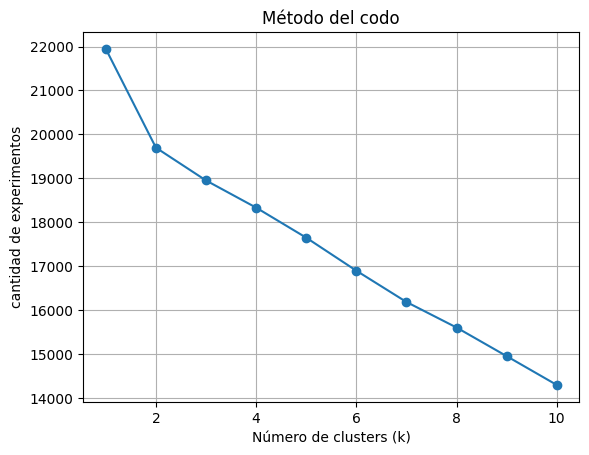

In [4]:
# Utilizar la técnica del codo para sugerencias de cantidad de clusters óptimos

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('cantidad de experimentos')
plt.title('Método del codo')
plt.grid(True)
plt.show()

In [5]:
#Aplicación del algoritmo K-means con la cantidad de grupos k

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_df['GRUPO_kmeans'] = kmeans.fit_predict(scaled_data)
cluster_df['GRUPO_kmeans']

0      0
1      0
2      1
3      1
4      1
      ..
660    1
661    0
662    1
663    0
664    0
Name: GRUPO_kmeans, Length: 665, dtype: int32

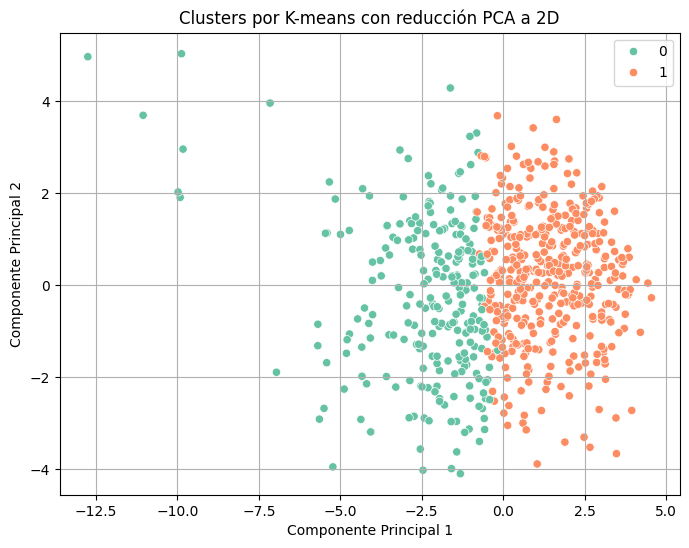

In [6]:
# Visualización con PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Scaled_pca = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Scaled_pca[:, 0], y=Scaled_pca[:, 1], hue=cluster_df['GRUPO_kmeans'], palette='Set2')
plt.title('Clusters por K-means con reducción PCA a 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

labels = cluster_df['GRUPO_kmeans']

#Métricas a calcular
sil_score = silhouette_score(scaled_data, labels)
cal_score = calinski_harabasz_score(scaled_data, labels)
dav_score = davies_bouldin_score(scaled_data, labels)

#Los resultados a mostrar por pantalla
print(f'Silhouette Score: {sil_score:.3f} (ideal >= 0.5)')
print(f'Calinski-Harabasz Score: {cal_score:.3f} (ideal >= 0)')
print(f'Davies-Bouldin Score: {dav_score:.3f} (ideal <= 0)')

Silhouette Score: 0.118 (ideal >= 0.5)
Calinski-Harabasz Score: 75.622 (ideal >= 0)
Davies-Bouldin Score: 2.699 (ideal <= 0)


# 2. Agrupamiento por DBSCAN

In [8]:
from sklearn.cluster import DBSCAN

#Para no usar el data frame del método Kmeans, se carga otro dataframe
# con el fin de ser usado con DBSCAN
cluster_db = pd.read_csv('df_cluster_27jun.csv')


#Una vez más colocar en la misma escala a los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_db)

#Uso de la herramienta SKL para hacer el agrupamiento con DBSCAN
dbscan = DBSCAN(eps=14, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

#Al dataframe de cluster_dv añadir nueva variable que identifica al grupo
#asignado a cada una de las muestras
cluster_db['GRUPO_dbscan'] = labels

#Evaluar número de grupos asignados por el algoritmo DBSCAN
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

#Evaluar el silhouette score -Esperando que haya más de un grupo-
if n_clusters > 1:
    sil_scoredb = silhouette_score(X_scaled, labels)
    print(f"número de clusters (NO ruido): {n_clusters}")
    print(f"índice del slihouette: {sil_scoredb: .4f} (ideal >= 0.5)")
else:
  print("DBSCAN detectó menos de 2 clusters, no se puede calcular el silhoutte score.")

DBSCAN detectó menos de 2 clusters, no se puede calcular el silhoutte score.


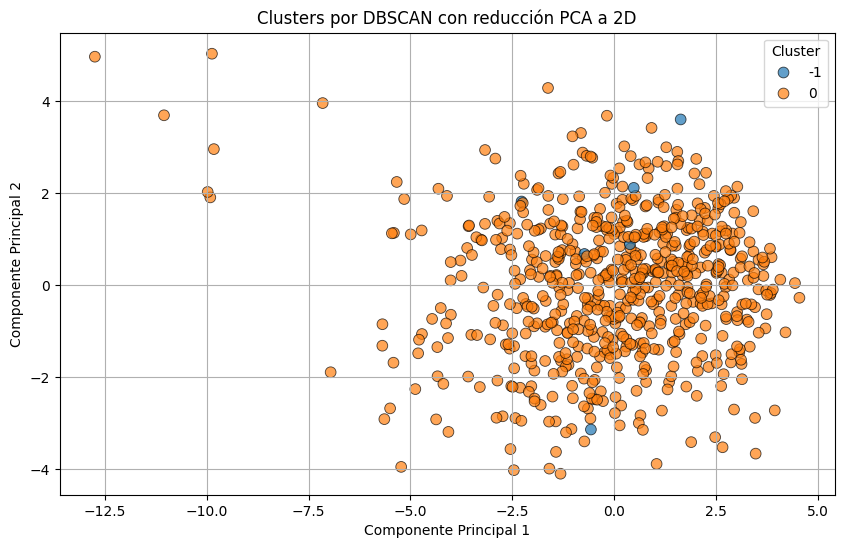

In [9]:
#VISUALIZACIÓN MEDIANTE REDUCCIÓN DE DIMENSIONES PARA DESCUBRIR LO HECHO POR DBSCAN

#Reducción a dos dimensiones para poder hacer la gráfica en plano coordenado.

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#No escribir sobre los datos origniales al graficar
df_graf = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_graf['Cluster'] = cluster_db['GRUPO_dbscan'].astype(str) # Convertir a string para mostrar '-1' como ruido

#Graficar
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_graf, palette='tab10', s=60, edgecolor='black', alpha=0.7)
plt.title('Clusters por DBSCAN con reducción PCA a 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

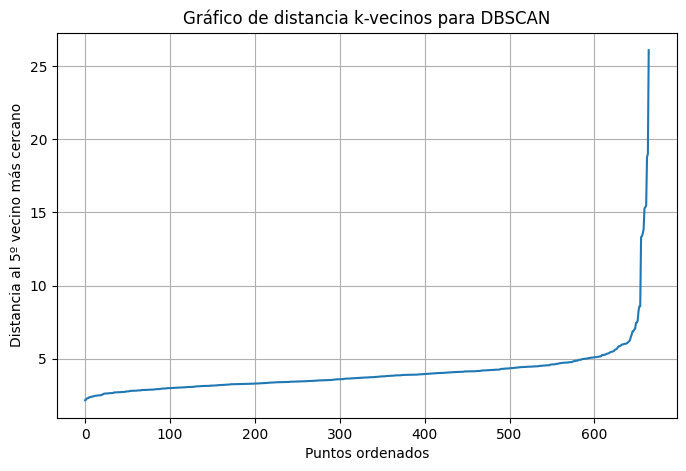

In [10]:
# Gráfico K-distance  para elegir mejores hiperparámetros.
from sklearn.neighbors import NearestNeighbors
import numpy as np

min_samples = 5  # Puedes ajustar este valor
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Distancias al k-ésimo vecino más cercano (posición -1)
k_distances = np.sort(distances[:, -1])

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {min_samples}º vecino más cercano")
plt.title("Gráfico de distancia k-vecinos para DBSCAN")
plt.grid(True)
plt.show()